### Step 1: Dataset Simulation

In [56]:
!pip install seaborn # Visualising Library
import pandas as pd # pandas for data manipulation and analysis. In this code we use it to show scatter plots.
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 

from datetime import datetime
from sklearn.preprocessing import scale 
#Seaborn is a library for making statistical graphics in Python. 
#It builds on top of matplotlib and integrates closely with pandas data structures. 
#Seaborn helps you explore and understand your data.
import seaborn as sb
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler 

from matplotlib import pyplot as plt # We use matplotlib for create axe and figures to plot data 
from pyspark.ml.feature import VectorAssembler 
from pyspark.sql.types import DoubleType 
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col # For use the column name of the dataframe in pyspark 
from pyspark.sql import SparkSession
from sklearn.linear_model import LinearRegression

In [57]:
# Constants for the simulated energy consumption data
num_households = 20
households = [f"Household {i+1}" for i in range(num_households)]
num_days = 365  # days in a year

# Generate random energy consumption data (in kWh)
np.random.seed(0)  # for reproducibility
data = {household: np.random.normal(loc=20, scale=5, size=num_days).clip(min=0) for household in households}
dates = pd.date_range(start="2020-01-01", periods=num_days)
energy_df = pd.DataFrame(data, index=dates)

# Saving to CSV file
energy_csv_file = "simulated_energy_consumption.csv"
energy_df.to_csv(energy_csv_file, index=True)

energy_df


,Household 1,Household 2,Household 3,Household 4,Household 5,Household 6,Household 7,Household 8,Household 9,Household 10,Household 11,Household 12,Household 13,Household 14,Household 15,Household 16,Household 17,Household 18,Household 19,Household 20
2020-01-01,28.820262,20.804641,17.473208,19.548781,28.806331,12.743308,19.944322,21.700123,26.260010,27.805493,21.460608,25.009604,22.685173,17.653889,18.415440,30.717028,15.906260,13.978742,28.144090,14.245338
2020-01-02,22.000786,19.046733,15.921042,23.658295,23.770478,20.109287,26.720372,24.315086,14.276537,14.342304,17.040459,20.884462,18.565824,30.641977,12.065674,17.745615,23.729153,18.723554,18.267907,25.931171
2020-01-03,24.893690,18.025752,17.462412,19.672558,16.874863,20.212695,22.500083,17.051511,19.543665,18.518842,30.907993,14.559927,28.172028,18.053796,23.943435,22.325537,9.448165,25.411331,14.906169,15.383996
2020-01-04,31.204466,18.661332,14.740599,21.740846,18.048037,27.654662,12.841011,18.637336,17.992147,11.429717,22.197751,18.733913,22.856133,22.848065,20.686124,18.061280,25.364118,20.212848,20.673310,12.565885
2020-01-05,29.337790,14.359943,32.486002,23.316290,20.562788,20.462239,16.855096,23.687608,22.810066,20.796171,18.344083,25.491365,16.050230,18.628503,16.074097,16.966322,28.656424,17.065433,19.296472,26.443534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,23.492286,15.564095,15.604197,16.166476,16.128525,26.252849,12.691308,15.138410,21.658452,18.957003,17.781986,25.331362,15.149603,25.692991,26.597449,25.062136,20.223550,19.534880,16.752440,17.495364
2020-12-27,20.018854,15.336055,18.844492,14.978386,18.653051,18.827310,12.256019,18.597761,19.171856,21.487028,16.649884,21.894302,26.226883,19.974876,19.398377,18.481299,16.536633,21.848286,28.028868,26.524637
2020-12-28,24.659242,26.216597,11.805963,15.009041,24.126861,15.683222,20.632844,14.098572,17.974469,21.815423,20.760821,14.106917,23.484357,24.857938,14.728452,19.472956,27.469903,18.036072,12.717422,14.149697
2020-12-29,21.699825,24.063370,16.333436,13.134787,18.508384,14.821971,23.965035,25.060841,28.726423,18.157818,10.297333,23.794979,19.677240,21.511706,6.205362,22.618842,16.724733,20.756278,19.203766,22.136685


### Step 2: Convert Days to Months

In [58]:
# Convert days to months
energy_df_monthly = energy_df.resample('M').sum()
energy_df_monthly

,Household 1,Household 2,Household 3,Household 4,Household 5,Household 6,Household 7,Household 8,Household 9,Household 10,Household 11,Household 12,Household 13,Household 14,Household 15,Household 16,Household 17,Household 18,Household 19,Household 20
2020-01-31,687.203204,564.089424,589.544925,672.927854,650.725219,596.514522,626.525036,609.503292,578.224854,585.844944,575.546983,642.797962,608.877691,619.965590,603.290570,647.779062,629.463485,655.651331,665.412359,635.818727
2020-02-29,535.796984,612.929326,571.021602,572.170380,554.476200,567.765542,558.027524,550.035952,583.437255,589.366036,597.501948,563.019486,617.196940,593.169267,564.176853,545.785781,550.705799,582.774465,561.588464,579.861735
2020-03-31,597.925966,615.457152,621.008964,668.121628,630.203959,620.832110,615.847875,637.784920,601.465073,608.088979,619.369149,566.978072,595.521384,640.770904,597.411524,627.808544,597.351336,632.546980,628.606445,615.815619
2020-04-30,680.523021,568.855660,617.875244,615.084192,613.866271,636.664075,601.554894,608.653734,567.787094,593.672301,590.212757,602.458143,586.010342,618.650368,579.433473,545.810975,616.347670,563.165086,662.315078,566.797819
2020-05-31,640.814048,619.004591,569.844734,645.832380,632.960175,633.205760,607.412563,575.895362,614.918191,636.115199,613.736200,607.356328,624.416360,601.494635,661.121232,634.039005,583.776124,571.640553,603.073802,606.795078
2020-06-30,573.042309,584.633372,583.873429,585.624989,591.068908,545.265844,586.209284,590.737691,592.697200,603.622108,568.845319,616.470777,640.385199,620.811263,606.755518,654.651935,592.264323,606.360740,547.200483,603.930326
2020-07-31,623.618361,590.889422,642.023999,580.110561,608.106086,647.592241,611.688538,601.162205,613.739123,624.443365,656.107417,584.254505,595.946660,665.336640,622.071490,617.774987,638.357853,619.372949,627.220497,596.629534
2020-08-31,590.966255,554.616473,686.784769,594.172198,664.658338,614.145052,643.420919,618.869282,601.883721,664.099087,603.991851,617.602440,624.987495,650.703839,626.604844,604.765392,621.126212,640.910780,650.467782,577.931281
2020-09-30,561.595211,590.200117,610.045844,620.565299,598.745982,630.835110,603.776624,587.734048,613.282126,606.452932,574.477513,584.523943,609.863368,590.355658,586.189027,605.261912,600.513321,576.545818,620.094045,592.880875
2020-10-31,650.907227,602.615195,608.716838,651.323220,601.239844,634.266770,603.710299,620.887521,555.862909,612.808319,608.196884,633.604602,598.946683,611.478262,659.828301,654.068187,616.547328,615.426792,647.978454,604.283330


In [59]:
# Transpose the DataFrame to have households as rows and weeks as columns
# energy_df_monthly_transposed = energy_df_monthly.T
# energy_df_monthly_transposed


### Step 3: Identify 3 Households with Highest Monthly Consumption

In [60]:
# Identify 3 households with the highest monthly consumption
top_3_households = energy_df_monthly.sum().nlargest(3).index
top_3_households


Index(['Household 19', 'Household 14', 'Household 4'], dtype='object')

### Step 4: Predict Next 6-Month Consumption

In [61]:
# Predict their next 6-month consumption
models = {}
for household in top_3_households:
    X = np.arange(len(energy_df_monthly)).reshape(-1, 1)
    y = energy_df_monthly[household].values
    model = LinearRegression()
    model.fit(X, y)
    future_months = np.arange(len(energy_df_monthly), len(energy_df_monthly) + 6).reshape(-1, 1)
    predictions = model.predict(future_months)
    models[household] = predictions
models

{'Household 19': array([615.68262344, 615.2814213 , 614.88021916, 614.47901702,
        614.07781488, 613.67661274]),
 'Household 14': array([604.23909498, 602.44063515, 600.64217532, 598.8437155 ,
        597.04525567, 595.24679584]),
 'Household 4': array([587.58655851, 583.5180482 , 579.4495379 , 575.38102759,
        571.31251728, 567.24400698])}

### Step 5: Clustering with Elbow Method

/Users/atie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/atie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/atie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/atie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

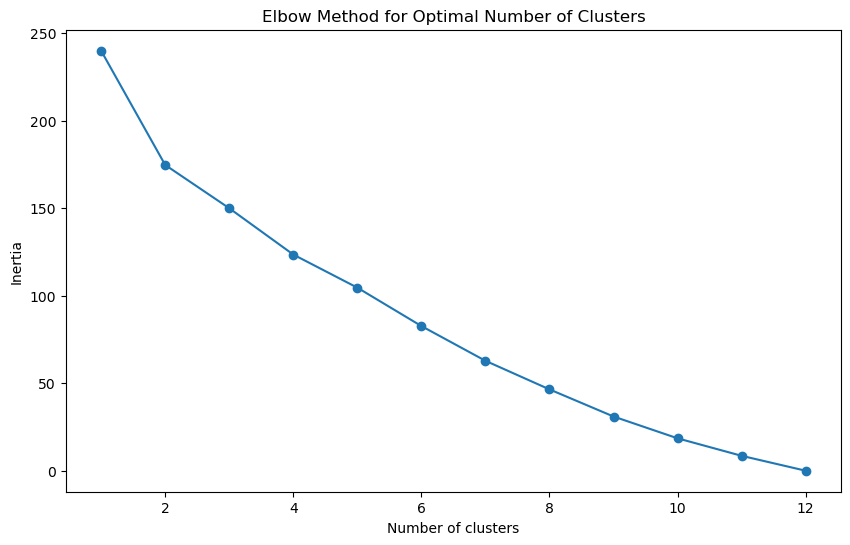

In [62]:
# Use clustering with elbow method on households
scaler = StandardScaler()
X_scaled = scaler.fit_transform(energy_df_monthly)  # Scale the monthly data

inertia = []
range_values = range(1, 13)
for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range_values, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()



### Step 6: Visualization

In [63]:
# Assuming optimal clusters chosen based on Elbow Method (e.g., 3)
optimal_k = 3  # This should be determined from the Elbow plot
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans_optimal.fit_predict(X_scaled)



/Users/atie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [64]:
#Add cluster labels to the monthly DataFrame for visualization
energy_df_monthly['Cluster'] = clusters

# Melt the DataFrame for visualization
df_melted = energy_df_monthly.reset_index().melt(id_vars=['index', 'Cluster'], var_name='Month', value_name='Energy Consumption')


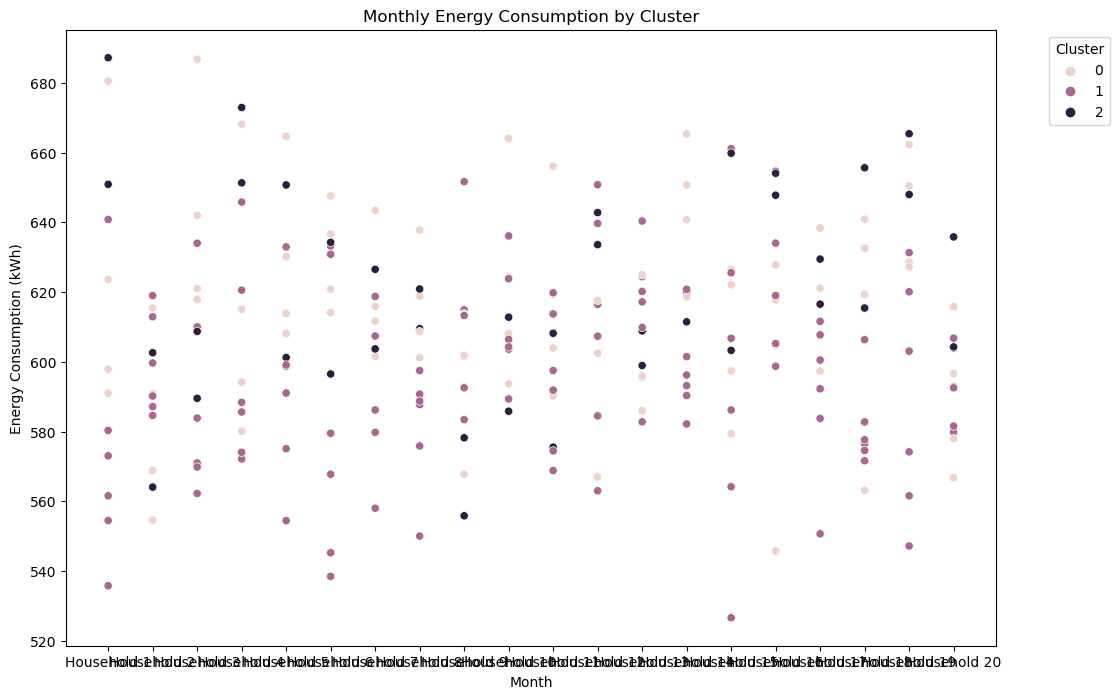

In [65]:
plt.figure(figsize=(12, 8))
sb.scatterplot(data=df_melted, x='Month', y='Energy Consumption', hue='Cluster')
plt.title('Monthly Energy Consumption by Cluster')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Step 7: Evaluate Clustering

In [66]:
# Silhouette Score to evaluate clustering
score = silhouette_score(energy_df_monthly, clusters)
print('Silhouette Score:', score)

Silhouette Score: 0.12228891472594333
